In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import glob
import powerlaw
import matplotlib.cm as cm
import matplotlib.colors as colors
import illustris_python as il
import matplotlib.gridspec as gridspec

path_custom_style = "/vera/u/jerbo/matplotlib_custom_style/scientific.mplstyle"
mpl.style.use(path_custom_style)

In [2]:
output_dir = f"/vera/ptmp/gc/jerbo/TNG-arepo-256_output/test/"
snapN = 5

snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
snap_files = os.listdir(snapdir)

for file_name in snap_files:
    print("-------------- File begin ----------------")
    file_path = snapdir+f"/{file_name}"
    print(file_path)
    
    with h5py.File(file_path, "r") as f:
        header = f['Header']
        for key, val in header.attrs.items():
            print(f"{key}: {val}")
    
        boxsize = header.attrs['BoxSize']/1e3  # in Mpc
    print("--------------- File end ------------------")

-------------- File begin ----------------
/vera/ptmp/gc/jerbo/TNG-arepo-256_output/test/snapdir_005/snap_005.2.hdf5
BoxSize: 25000.0
Composition_vector_length: 0
Flag_Cooling: 1
Flag_DoublePrecision: 0
Flag_Feedback: 1
Flag_Metals: 0
Flag_Sfr: 1
Flag_StellarAge: 0
Git_commit: b'2a814e756e7b47c056b5a26c824f2d90ef1a0738'
Git_date: b'Tue Sep 2 12:42:11 2025 +0200'
HubbleParam: 0.6774
MassTable: [0.         0.00672772 0.         0.00125612 0.         0.        ]
NumFilesPerSnapshot: 8
NumPart_ThisFile: [2005416 2096794       0 2066098   63604     154]
NumPart_Total: [15996976 16777216        0 16777216   607329     1257]
NumPart_Total_HighWord: [0 0 0 0 0 0]
Omega0: 0.3089
OmegaBaryon: 0.0486
OmegaLambda: 0.6911
Redshift: 2.220446049250313e-16
Time: 0.9999999999999998
UnitLength_in_cm: 3.085678e+21
UnitMass_in_g: 1.989e+43
UnitVelocity_in_cm_per_s: 100000.0
--------------- File end ------------------
-------------- File begin ----------------
/vera/ptmp/gc/jerbo/TNG-arepo-256_output/test/

In [3]:
def get_data_from_fof_folder(output_dir, snapN, param1, param2):
    snapdir = glob.glob(output_dir+f"groups_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    # print(snap_files)
    
    all_values = np.array([])

    for file_name in snap_files:
        # print("-------------- File begin ----------------")
        file_path = snapdir+f"/{file_name}"
        # print(file_path)

        with h5py.File(file_path, "r") as f:
            # header = f['Header']
            # for key, val in header.attrs.items():
                # print(f"{key}: {val}")
            values_this_file = f[f'{param1}/{param2}'][:]
            all_values = np.concatenate((all_values, values_this_file))
            
            # print(values_this_file.shape)
            # print(all_values.shape)
        
        # print("--------------- File end ------------------")
    
    return all_values


def get_boxsize(output_dir, snapN):
    snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
    snap_file = os.listdir(snapdir)[0]
    file_path = snapdir+f"/{snap_file}"
    
    with h5py.File(file_path, "r") as f:
        header = f['Header'] 
        boxsize = header.attrs['BoxSize']/1e3  # in Mpc
        
    return boxsize

def get_cosmo_parameters(basepath):
    path = basepath+"parameters-usedvalues"
    Omega0 = None
    OmegaLambda = None
    HubbleParam = None
    
    with open(path, "r") as f:
        for line in f:
            if "Omega0" in line:
                Omega0 = float(line.split()[-1])
            if "OmegaLambda" in line:
                OmegaLambda = float(line.split()[-1])
            if "HubbleParam" in line:
                HubbleParam = float(line.split()[-1])
    
    return Omega0, OmegaLambda, HubbleParam


def get_halo_mass_function(subhalo_masses, box_size, n_bins=50, log_binning=True):

    ############# Create log bins #############
    subhalo_masses = subhalo_masses * 1e10  # convert to solar masses

    min_subhalo_mass = np.log10(subhalo_masses.min())
    max_subhalo_mass = round(np.log10(subhalo_masses.max()))

    if min_subhalo_mass <= 1:
        min_subhalo_mass = 1
    else:
        min_subhalo_mass = round(min_subhalo_mass)   

    log_bins = np.logspace(min_subhalo_mass, max_subhalo_mass, n_bins+1)
    # log_bins = np.logspace(1, 5, n_bins+1)

    #############                 #############

    if log_binning:
        bins = log_bins
    else:
        bins = n_bins

    ############ Create Histrogram #############

    y_vals, edges = np.histogram(subhalo_masses, bins=bins)
    bin_centers = np.array([(edges[i+1]-edges[i])/2+edges[i] for i in range(len(y_vals))])
    
    y_vals = y_vals/(box_size**3)
    
    return bin_centers, y_vals

In [4]:
output_dir = f"/vera/ptmp/gc/jerbo/L25n128_suite"
snapN = 5
param1 = "Group"
param2 = "GroupMass"

#print(get_data_from_fof_folder(output_dir, snapN, param1, param2))
#print(get_cosmo_parameters(output_dir))

In [5]:
n_gridpoints = range(50)

bin_center_lists = []
halocount_lists =[]
Omega0s = []
OmegaLambdas = []
HubbleParams = []

for gp in n_gridpoints: # TODO: change this to loop over the actual output directories
    
    path = output_dir + f"/gridpoint{gp}/" # TODO: change this to loop over the actual output directories
    
    box_size = get_boxsize(path, snapN)
    
    subhalo_masses = get_data_from_fof_folder(path, snapN, 'Group', 'GroupMass')
    
    bin_centers, y_vals = get_halo_mass_function(subhalo_masses, box_size)
    
    bin_center_lists.append(bin_centers) #  convert to solar masses
    halocount_lists.append(y_vals)
    
    Omega0, OmegaLambda, HubbleParam = get_cosmo_parameters(path)
    
    Omega0s.append(Omega0)
    OmegaLambdas.append(OmegaLambda)
    HubbleParams.append(HubbleParam)

In [6]:
# sort grid paths for specitifc parameter
tmp = []
for i in n_gridpoints:
    Omega0, OmegaLambda, HubbleParam = get_cosmo_parameters(output_dir+f"/gridpoint{i}/")
    tmp.append(Omega0)

index_map = range(len(tmp))
_ , sorted_indices = zip(*sorted(zip(tmp, index_map), reverse=True))

In [7]:
sorted_halocount_lists = np.copy(halocount_lists)
sorted_bin_center_lists = np.copy(bin_center_lists)
sorted_Omega0s = np.copy(Omega0s)
sorted_OmegaLambdas = np.copy(OmegaLambdas)
sorted_HubbleParams = np.copy(HubbleParams)

for i in range(len(sorted_indices)):
    sorted_halocount_lists[i] = halocount_lists[sorted_indices[i]]
    sorted_bin_center_lists[i] = bin_center_lists[sorted_indices[i]]
    sorted_Omega0s[i] = Omega0s[sorted_indices[i]]
    sorted_OmegaLambdas[i] = OmegaLambdas[sorted_indices[i]]
    sorted_HubbleParams[i] = HubbleParams[sorted_indices[i]]
    
halocount_lists = sorted_halocount_lists
bin_center_lists = sorted_bin_center_lists
Omega0s = sorted_Omega0s
OmegaLambdas = sorted_OmegaLambdas
HubbleParams = sorted_HubbleParams

In [8]:
tng_50_path = "/virgotng/universe/IllustrisTNG/TNG50-3/output"
subhalos_tng_50 = il.groupcat.loadHalos(tng_50_path,99)
subhalos_tng_50 = subhalos_tng_50['GroupMass']
boxsize_tng_50 = il.groupcat.loadHeader(tng_50_path, 99)['BoxSize']/1e3 #  convert to Mpc

tng_100_path = "/virgotng/universe/IllustrisTNG/TNG100-3/output"
subhalos_tng_100 = il.groupcat.loadHalos(tng_100_path,99)
subhalos_tng_100 = subhalos_tng_100['GroupMass']
boxsize_tng_100 = il.groupcat.loadHeader(tng_100_path, 99)['BoxSize']/1e3 #  convert to Mpc

tng_300_path = "/virgotng/universe/IllustrisTNG/TNG300-3/output"
subhalos_tng_300 = il.groupcat.loadHalos(tng_300_path,99)
subhalos_tng_300 = subhalos_tng_300['GroupMass']
boxsize_tng_300 = il.groupcat.loadHeader(tng_300_path, 99)['BoxSize']/1e3 #  convert to Mpc

lower_number_cutoff = 6.4e-5  # cut of lines in plot if number of halos drops below 3 and plot rest as points

fig = plt.figure(figsize=(10,8))

norm = colors.Normalize(vmin=min(Omega0s), vmax=max(Omega0s))
colormap = cm.viridis  # Choose any colormap: viridis, plasma, inferno, etc.
scalar_map = cm.ScalarMappable(norm=norm, cmap=colormap)

for i in range(len(bin_center_lists)):
    color = scalar_map.to_rgba(Omega0s[i])
    
    first_non_zero = np.where(halocount_lists[i]!=0)[0][0]
    if first_non_zero:
        halocount_lists_nice = halocount_lists[i][first_non_zero:]
        bin_center_lists_nice = bin_center_lists[i][first_non_zero:]
    else:
        halocount_lists_nice = halocount_lists[i]
        bin_center_lists_nice = bin_center_lists[i]
        
    l_halocount_list_half = round(len(halocount_lists_nice)/2)
    _temp = np.where(halocount_lists_nice[l_halocount_list_half:]<lower_number_cutoff)[0]
    _temp += l_halocount_list_half
    
    if len(_temp) == 0:
        plt.plot(bin_center_lists_nice, halocount_lists_nice, color=color)
    else:
        
        cutoff_index = _temp[0]

        plt.plot(bin_center_lists_nice[:cutoff_index], halocount_lists_nice[:cutoff_index], color=color)
        plt.plot(bin_center_lists_nice[cutoff_index:], halocount_lists_nice[cutoff_index:], color=color,
                 marker="o", linestyle="None", alpha=0.5)
    
cbar = plt.colorbar(scalar_map)
cbar.set_label(r'$\Omega_m$', fontsize=13)

################# Plot reference lines from TNG 50 Simulation #################

bin_centers_tng_50, y_vals_tng_50 = get_halo_mass_function(subhalos_tng_50, boxsize_tng_50)

# cut off numerical artifact tails from reference
bin_centers_tng_50, y_vals_tng_50 = bin_centers_tng_50[6:], y_vals_tng_50[6:]

l_y_vals_tng_50_half = round(len(y_vals_tng_50)/2)
_temp = np.where(y_vals_tng_50[l_y_vals_tng_50_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_50_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_50, y_vals_tng_50, color="black", linestyle="-.", linewidth=5, label="TNG50 Dark")
else:
    cutoff_index_tng_50 = _temp[0]
    
    plt.plot(bin_centers_tng_50[:cutoff_index_tng_50], y_vals_tng_50[:cutoff_index_tng_50], color="black",
             linestyle="-.", linewidth=5, label="TNG 50 Dark")
    plt.plot(bin_centers_tng_50[cutoff_index_tng_50:], y_vals_tng_50[cutoff_index_tng_50:], color="black",
             marker="o", linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 100 Simulation #################
    
bin_centers_tng_100, y_vals_tng_100 = get_halo_mass_function(subhalos_tng_100, boxsize_tng_100)

# cut off numerical artifact tails from reference
bin_centers_tng_100, y_vals_tng_100 = bin_centers_tng_100[8:], y_vals_tng_100[8:]

l_y_vals_tng_100_half = round(len(y_vals_tng_100)/2)
_temp = np.where(y_vals_tng_100[l_y_vals_tng_100_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_100_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_100, y_vals_tng_100, color="black", linestyle="--", linewidth=5, label="TNG100 Dark")
    
else:
    cutoff_index_tng_100 = _temp[0]
    
    plt.plot(bin_centers_tng_100[:cutoff_index_tng_100], y_vals_tng_100[:cutoff_index_tng_100], color="black",
             linestyle="--", linewidth=5, label="TNG100 Dark")
    plt.plot(bin_centers_tng_100[cutoff_index_tng_100:], y_vals_tng_100[cutoff_index_tng_100:], color="black",
             marker="o", linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 300 Simulation #################
    
bin_centers_tng_300, y_vals_tng_300 = get_halo_mass_function(subhalos_tng_300, boxsize_tng_300)

# cut off numerical artifact tails from reference
bin_centers_tng_300, y_vals_tng_300 = bin_centers_tng_300[8:], y_vals_tng_300[8:]

l_y_vals_tng_300_half = round(len(y_vals_tng_300)/2)
_temp = np.where(y_vals_tng_300[l_y_vals_tng_300_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_300_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_300, y_vals_tng_300, color="black", linestyle="-", linewidth=5, label="TNG300 Dark")
    
else:
    cutoff_index_tng_300 = _temp[0]
    
    plt.plot(bin_centers_tng_300[:cutoff_index_tng_300], y_vals_tng_300[:cutoff_index_tng_300], color="black",
             linestyle="-", linewidth=5, label="TNG300 Dark")
    plt.plot(bin_centers_tng_300[cutoff_index_tng_300:], y_vals_tng_300[cutoff_index_tng_300:], color="black",
             marker="o", linestyle="None", alpha=0.5)

#################                                             #################

plt.yscale("log")
plt.xscale("log")
plt.ylim([3e-5, 1e-1])
plt.xlim([1.5e10, 2e14])
plt.ylabel(r"Number of Halos in $Mpc^{-3}$", fontsize=17)
plt.xlabel(r"Halo mass in $M_{\odot}$", fontsize=17)
plt.legend(handlelength=2, handletextpad=0.5)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
# plt.savefig("plots/halo_mass_functions.pdf", format="PDF")
plt.show()

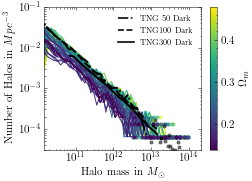

In [9]:
# mpl.rcParams['lines.linewidth'] = .5

lower_number_cutoff = 6.4e-5  # cut of lines in plot if number of halos drops below 3 and plot rest as points

fig = plt.figure()
plt.yscale("log")
plt.xscale("log")

norm = colors.Normalize(vmin=min(Omega0s), vmax=max(Omega0s))
colormap = cm.viridis  # Choose any colormap: viridis, plasma, inferno, etc.
scalar_map = cm.ScalarMappable(norm=norm, cmap=colormap)

for i in range(len(bin_center_lists)):
    color = scalar_map.to_rgba(Omega0s[i])
    
    first_non_zero = np.where(halocount_lists[i]!=0)[0][0]
    if first_non_zero:
        halocount_lists_nice = halocount_lists[i][first_non_zero:]
        bin_center_lists_nice = bin_center_lists[i][first_non_zero:]
    else:
        halocount_lists_nice = halocount_lists[i]
        bin_center_lists_nice = bin_center_lists[i]
        
    l_halocount_list_half = round(len(halocount_lists_nice)/2)
    _temp = np.where(halocount_lists_nice[l_halocount_list_half:]<lower_number_cutoff)[0]
    _temp += l_halocount_list_half
    
    if len(_temp) == 0:
        plt.plot(bin_center_lists_nice, halocount_lists_nice, color=color)
    else:
        
        cutoff_index = _temp[0]

        plt.plot(bin_center_lists_nice[:cutoff_index], halocount_lists_nice[:cutoff_index], color=color)
        plt.plot(bin_center_lists_nice[cutoff_index:], halocount_lists_nice[cutoff_index:], color=color,
                 marker="o", markersize=3, linestyle="None", alpha=0.5)
    
cbar = plt.colorbar(scalar_map)
cbar.set_label(r'$\Omega_m$')

################# Plot reference lines from TNG 50 Simulation #################

bin_centers_tng_50, y_vals_tng_50 = get_halo_mass_function(subhalos_tng_50, boxsize_tng_50)

# cut off numerical artifact tails from reference
bin_centers_tng_50, y_vals_tng_50 = bin_centers_tng_50[6:], y_vals_tng_50[6:]

l_y_vals_tng_50_half = round(len(y_vals_tng_50)/2)
_temp = np.where(y_vals_tng_50[l_y_vals_tng_50_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_50_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_50, y_vals_tng_50, color="black", linestyle="-.", linewidth=2, label="TNG50 Dark")
else:
    cutoff_index_tng_50 = _temp[0]
    
    plt.plot(bin_centers_tng_50[:cutoff_index_tng_50], y_vals_tng_50[:cutoff_index_tng_50], color="black",
             linestyle="-.", linewidth=2, label="TNG 50 Dark")
    plt.plot(bin_centers_tng_50[cutoff_index_tng_50:], y_vals_tng_50[cutoff_index_tng_50:], color="black",
             marker="o", markersize=3, linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 100 Simulation #################
    
bin_centers_tng_100, y_vals_tng_100 = get_halo_mass_function(subhalos_tng_100, boxsize_tng_100)

# cut off numerical artifact tails from reference
bin_centers_tng_100, y_vals_tng_100 = bin_centers_tng_100[8:], y_vals_tng_100[8:]

l_y_vals_tng_100_half = round(len(y_vals_tng_100)/2)
_temp = np.where(y_vals_tng_100[l_y_vals_tng_100_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_100_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_100, y_vals_tng_100, color="black", linestyle="--", linewidth=2, label="TNG100 Dark")
    
else:
    cutoff_index_tng_100 = _temp[0]
    
    plt.plot(bin_centers_tng_100[:cutoff_index_tng_100], y_vals_tng_100[:cutoff_index_tng_100], color="black",
             linestyle="--", linewidth=2, label="TNG100 Dark")
    plt.plot(bin_centers_tng_100[cutoff_index_tng_100:], y_vals_tng_100[cutoff_index_tng_100:], color="black",
             marker="o", markersize=3, linestyle="None", alpha=0.5)

################# Plot reference lines from TNG 300 Simulation #################
    
bin_centers_tng_300, y_vals_tng_300 = get_halo_mass_function(subhalos_tng_300, boxsize_tng_300)

# cut off numerical artifact tails from reference
bin_centers_tng_300, y_vals_tng_300 = bin_centers_tng_300[8:], y_vals_tng_300[8:]

l_y_vals_tng_300_half = round(len(y_vals_tng_300)/2)
_temp = np.where(y_vals_tng_300[l_y_vals_tng_300_half:]<lower_number_cutoff)[0]
_temp += l_y_vals_tng_300_half

if len(_temp) == 0:
    plt.plot(bin_centers_tng_300, y_vals_tng_300, color="black", linestyle="-", linewidth=2, label="TNG300 Dark")
    
else:
    cutoff_index_tng_300 = _temp[0]
    
    plt.plot(bin_centers_tng_300[:cutoff_index_tng_300], y_vals_tng_300[:cutoff_index_tng_300], color="black",
             linestyle="-", linewidth=2, label="TNG300 Dark")
    plt.plot(bin_centers_tng_300[cutoff_index_tng_300:], y_vals_tng_300[cutoff_index_tng_300:], color="black",
             marker="o", markersize=3, linestyle="None", alpha=0.5)

#################                                             #################

plt.ylim([3e-5, 1e-1])
plt.xlim([1.5e10, 2e14])

from matplotlib.ticker import LogLocator
ax = plt.gca()  # get current axes
# Set major and minor ticks explicitly
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0, ), numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)*0.1, numticks=100))


plt.ylabel(r"Number of Halos in $Mpc^{-3}$")
plt.xlabel(r"Halo mass in $M_{\odot}$")
leg = plt.legend(fontsize=8)
for line in leg.get_lines():
    line.set_linewidth(1.6)
plt.savefig("plots/halo_mass_functions.pdf", format="PDF")
plt.show()